In [440]:
 %matplotlib inline
import pandas as pd
import datetime
from scipy import interpolate
import numpy as np 
import matplotlib.pyplot as plt

In [296]:
base_date = '20180731'

In [297]:
root_path = '/Users/susynishida/Desktop/dev/Python/Finance/discount_factor/'

In [298]:
IR_input = '/IR.csv'

In [299]:
df_IR = pd.read_csv(root_path + 'input/' + base_date + IR_input)

In [420]:
df_IR['Tenor'].apply(lambda x: df_IR['Rate'][df_IR.query('Tenor == @x').index[0]] if x=='O/N' else 0)

0     0.019154
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
Name: Tenor, dtype: float64

In [414]:
df_IR

,Date,Money_market,Tenor,Currency,Rate,lag(day),Frequency(month),Dcc
0,2018/7/31,LIBOR,O/N,USD,0.019154,2,NaN,ACT/360
1,2018/7/31,LIBOR,1W,USD,0.019536,2,NaN,ACT/360
2,2018/7/31,LIBOR,1M,USD,0.020814,2,NaN,ACT/360
3,2018/7/31,LIBOR,2M,USD,0.021791,2,NaN,ACT/360
4,2018/7/31,LIBOR,3M,USD,0.023486,2,NaN,ACT/360
5,2018/7/31,LIBOR,6M,USD,0.025305,2,NaN,ACT/360
6,2018/7/31,SWAP,1Y,USD,0.026780,2,3.0,ACT/360
7,2018/7/31,SWAP,2Y,USD,0.028810,2,3.0,ACT/360
8,2018/7/31,SWAP,3Y,USD,0.029440,2,3.0,ACT/360
9,2018/7/31,SWAP,4Y,USD,0.029660,2,3.0,ACT/360


In [249]:
df_IR.set_index('Tenor').at['O/N', 'Rate']

0.0191538

In [489]:
df_IR.query('Tenor == "1Y"').index

Int64Index([6], dtype='int64')

In [514]:
list(df_IR['Tenor'][0:3])

['O/N', '1W', '1M']

## function: library

In [473]:
def tenor_to_days(str_tenor):
    if(str_tenor=='O/N'):
        days = 1
    elif(str_tenor=='T/N'):
        days = 2
    elif(str_tenor[-1]=='W'):
        days = int(str_tenor[0:len(str_tenor)-1]) * 7
    elif(str_tenor[-1]=='M'):
        days = int(str_tenor[0:len(str_tenor)-1]) * 30
    elif(str_tenor[-1]=='Y'):
        days = int(str_tenor[0:len(str_tenor)-1]) * 365
    return days

def str_dcc_to_num(str_dcc):
    if(str_dcc=='ACT/360'):
        dcc_num = 360
    elif(str_dcc=='ACT/365F'):
        dcc_num = 365
    return dcc_num

def interpolation_swap_rate(array_x, array_y, str_kind):
    f = interpolate.interp1d(array_x, array_y, kind=str_kind)
    return f

## class: calc discount factor

In [614]:
class discount_factor():
    def __init__(self, df, str_ccy):
        self._df_ir = df[df['Currency']==str_ccy]
        self._base_date_obj = datetime.datetime.strptime(self._df_ir['Date'][0], '%Y/%m/%d')
        self._spot_date = self._base_date_obj + datetime.timedelta(days=int(self._df_ir['lag(day)'][0]))
        self._frequency = self._df_ir.set_index('Currency').at[str_ccy, 'Frequency(month)']
        
    def get_raw_rate(self, str_tenor):
        return self._df_ir.set_index('Tenor').at[str_tenor, 'Rate']

    def calc_DF_short_term(self, str_tenor):
        short_term_rate = self.get_raw_rate(str_tenor)
        dcc = str_dcc_to_num(self._df_ir.set_index('Tenor').at[str_tenor, 'Dcc'])
        target_date_obj = self._base_date_obj + datetime.timedelta(days = int(tenor_to_days(str_tenor)))
        dfc = (target_date_obj - self._base_date_obj).days / dcc
        DF = 1 / ( 1 + dfc * short_term_rate)
        return DF
    
    def calc_DF_swap(self, str_tenor):
        swap_rate = self.get_raw_rate(str_tenor)
        return DF
    
    def get_array_swap_tenor(self):
        index_one_year = self._df_ir.query('Tenor == "1Y"').index[0]
        array_swap_tenor = self._df_ir['Tenor'][index_one_year:].apply(lambda x: int(x[0:len(x)-1]))
        list_array_swap_tenor = list(array_swap_tenor)
        return list_array_swap_tenor
    
    def get_array_swap_rate(self):
        index_one_year = self._df_ir.query('Tenor == "1Y"').index[0]
        array_swap_rate = self._df_ir['Rate'][index_one_year:]
        list_array_swap_rate = list(array_swap_rate.map(lambda x: float(x)))
        return list_array_swap_rate
    
    def interpolation_swap_rate(self, kind):
        array_x = self.get_array_swap_tenor()
        array_y = self.get_array_swap_rate()
        func = interpolation_swap_rate(array_x, array_y, kind)
        return func

## try space

In [609]:
DF_obj = discount_factor(df_IR, 'USD')

In [631]:
x_value = np.linspace(1,30,100)
y_value = DF_obj.interpolation_swap_rate('slinear')
y_value_c = DF_obj.interpolation_swap_rate('cubic')

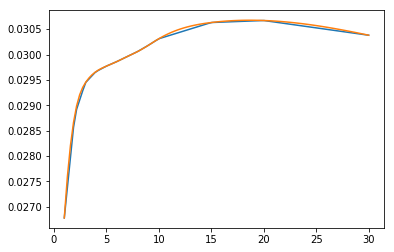

In [632]:
plt.plot(x_value, y_value(x_value))
plt.plot(x_value, y_value_c(x_value))

In [593]:
DF_obj.get_array_swap_rate()

[0.02678,
 0.028810000000000002,
 0.029439999999999997,
 0.029660000000000002,
 0.029769999999999998,
 0.02986,
 0.029960000000000004,
 0.030060000000000003,
 0.030180000000000002,
 0.030310000000000004,
 0.03063,
 0.03067,
 0.03038]

In [579]:
DF_obj.get_array_swap_tenor()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]

In [306]:
DF_obj.get_raw_rate('6M')

0.025305

In [286]:
DF_obj.calc_DF_short_term('6M')

0.9875055855784685

In [274]:
str_dcc_to_num('ACT/360')

360

In [275]:
tenor_to_days('1W')

7

### datetime

In [183]:
today_obj = datetime.datetime.now()
oneweek_obj = datetime.datetime.now() + datetime.timedelta(days=7)

In [185]:
(oneweek_obj -  today_obj).days

7

## list of error

In [268]:
df_IR[df_IR['Tenor']=='1M']['Rate'][0]

KeyError: 0